In [1]:
from mae.encoder import *
from mae.decoder import *
from dataset import *
import gin

In [2]:
gin.parse_config_file("config/encoder_config1.gin")
encoder_config = EncoderConfig()

gin.parse_config_file("config/decoder_config1.gin")
decoder_config = DecoderConfig()
# decoder_config.do_loss_calculation = False

In [3]:
decoder_config

DecoderConfig(image_size=128, in_proj_dim=256, hidden_size=256, intermediate_size=768, num_hidden_layers=4, num_attention_heads=2, num_channels=3, patch_size=8, norm_eps=1e-08, attention_dropout=0.0, do_loss_calculation=True, use_small_mlp=True, num_image_tokens=256, head_dim=128, patched_image_height=16, patched_image_width=16, rng_seed=42, rng_generator=<torch._C.Generator object at 0x0000012A9FAF6ED0>)

In [4]:
encoder = EncoderModel(encoder_config)
decoder = DecoderModel(decoder_config)

In [5]:
# img, class_name = next(iter(train_dataloader))
# img.shape, class_name

# sample input 
img = torch.randn(1, 3, 128, 128)

In [6]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

In [7]:
decoder_op[0].shape, img.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

In [8]:
decoder_op[1]

tensor(13335.0449, grad_fn=<SumBackward0>)

In [10]:
def expand_mask(mask, img_size=128, patch_size=8):
    """
    Expands a patch-level mask (batch_size, num_patches) into an image-level mask (batch_size, 1, H, W)
    """
    batch_size, num_patches = mask.shape
    grid_size = img_size // patch_size  # Number of patches along one dimension (128/8 = 16)

    # Reshape from (batch_size, num_patches) -> (batch_size, 1, grid_size, grid_size)
    mask = mask.view(batch_size, 1, grid_size, grid_size)

    # Upscale mask to image resolution (batch_size, 1, height, width)
    mask = F.interpolate(mask.float(), scale_factor=patch_size, mode="nearest")
    return mask  # Shape: (batch_size, 1, 128, 128)

def masked_pixel_loss(x_rec, x, mask):
    """
    Computes loss only on masked patches in the spatial domain.
    
    Args:
        x_rec: Reconstructed image tensor of shape (batch_size, channel, height, width)
        x: Original image tensor of shape (batch_size, channel, height, width)
        mask: Binary mask tensor of shape (batch_size, num_patches)
    
    Returns:
        Masked MSE loss
    """
    assert x_rec.shape == x.shape
    mask_expanded = expand_mask(mask, img_size=128, patch_size=8)  # Shape (batch_size, 1, 128, 128)
    
    loss = F.mse_loss(x_rec, x, reduction="none")  # Compute pixel-wise loss (batch_size, 3, 128, 128)
    loss = loss.mean(dim=1, keepdim=True)  # Average over channels → (batch_size, 1, 128, 128)

    masked_loss = (loss * mask_expanded).sum() / mask_expanded.sum()  # Compute loss only for masked areas
    return masked_loss

In [11]:
mse_loss = nn.MSELoss(reduction="mean")
mse_loss(img, decoder_op[0])/img.shape[0]

tensor(0.9621, grad_fn=<DivBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5933143..1.8762676].


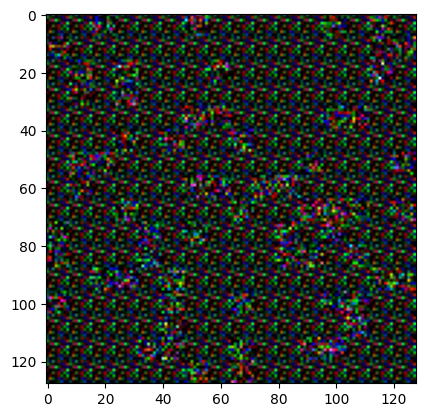

In [12]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));

In [13]:
from dataset import *

In [14]:
import os
files = os.listdir("dataset")
ds = Birddataset("dataset/", allowed_classes=files, dataset_type="train", do_transform=True)

In [15]:
train_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "train")
test_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "test")

In [16]:
train_dataset.__len__()
test_dataset.__len__()

12

In [17]:
train_dataset.__getitem__(0)

(tensor([[[0.3333, 0.3608, 0.3490,  ..., 0.6275, 0.6941, 0.6941],
          [0.3098, 0.3569, 0.3529,  ..., 0.6627, 0.6902, 0.6471],
          [0.3569, 0.3922, 0.3882,  ..., 0.6863, 0.7020, 0.6667],
          ...,
          [0.0980, 0.1333, 0.1804,  ..., 0.3373, 0.0431, 0.0275],
          [0.0980, 0.0824, 0.0706,  ..., 0.2745, 1.0000, 0.4980],
          [0.0000, 0.1490, 0.1490,  ..., 0.6863, 0.2784, 0.5490]],
 
         [[0.2431, 0.2706, 0.2627,  ..., 0.5647, 0.6314, 0.6314],
          [0.2196, 0.2706, 0.2667,  ..., 0.6000, 0.6275, 0.5843],
          [0.2706, 0.3059, 0.3020,  ..., 0.6314, 0.6471, 0.6118],
          ...,
          [0.1255, 0.1529, 0.1922,  ..., 0.1529, 0.0627, 0.1490],
          [0.1725, 0.1255, 0.0353,  ..., 0.1608, 0.8431, 0.3255],
          [0.0588, 0.1961, 0.0980,  ..., 0.6078, 0.0314, 0.2275]],
 
         [[0.1725, 0.2000, 0.1804,  ..., 0.3725, 0.4392, 0.4392],
          [0.1490, 0.1882, 0.1843,  ..., 0.4078, 0.4353, 0.3922],
          [0.1882, 0.2157, 0.2118,  ...,

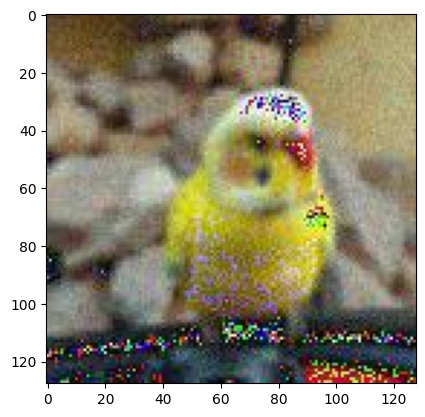

In [18]:
# plot train_dataset.__getitem__(0)[0] image
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0))

In [ ]:
from model import *
# load mae wrapper config
# gin.parse_config_file("config/wrapper_config1.gin")
wrapper_config = MAEWrapperConfig()

In [ ]:
wrapper_config

MAEWrapperConfig(lr=0.0003, batch_size=4, num_epochs=10, weight_decay=0.0001, eps=1e-08, seed=42, betas=(0.9, 0.999), gpu_count=1, device='cuda')

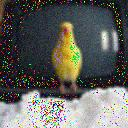

In [19]:
from PIL import Image
img = Image.open("dataset/budgie/38.jpg")
img

In [20]:
img.size

(128, 128)